In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from distutils.dir_util import copy_tree, remove_tree
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import DirectoryIterator
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from PIL import Image
from random import randint
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from bokeh.plotting import figure
from bokeh.palettes import viridis
from bokeh.models import ColumnDataSource
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix


c:\Users\Eng Gehad\anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
base_dir = "C:/Users/Gogo/OneDrive/Documents/Graduation Project/archive/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [3]:
WORK_DIR = './dataset/'

IMG_SIZE = 150
IMAGE_SIZE = [150, 150]
DIM = (IMG_SIZE, IMG_SIZE)


In [4]:
#Performing Image Augmentation to have more data samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


In [5]:
filepaths = []
labels = []

folds = os.listdir(train_dir)
for fold in folds:
    foldpath = os.path.join(train_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)


In [6]:
# Generate  test data paths with labels
filepaths = []
labels = []

folds = os.listdir(test_dir)
for fold in folds:
    foldpath = os.path.join(test_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)
test_df


,filepaths,labels
0,C:/Users/Eng Gehad/Documents/Graduation Projec...,MildDemented
1,C:/Users/Eng Gehad/Documents/Graduation Projec...,MildDemented
2,C:/Users/Eng Gehad/Documents/Graduation Projec...,MildDemented
3,C:/Users/Eng Gehad/Documents/Graduation Projec...,MildDemented
4,C:/Users/Eng Gehad/Documents/Graduation Projec...,MildDemented
...,...,...
1274,C:/Users/Eng Gehad/Documents/Graduation Projec...,VeryMildDemented
1275,C:/Users/Eng Gehad/Documents/Graduation Projec...,VeryMildDemented
1276,C:/Users/Eng Gehad/Documents/Graduation Projec...,VeryMildDemented
1277,C:/Users/Eng Gehad/Documents/Graduation Projec...,VeryMildDemented


In [7]:
# valid and test dataframe
valid_df, test_df = train_test_split(test_df,  train_size= 0.6, shuffle= True, random_state= 123)


In [8]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5121 validated image filenames belonging to 4 classes.
Found 767 validated image filenames belonging to 4 classes.
Found 512 validated image filenames belonging to 4 classes.


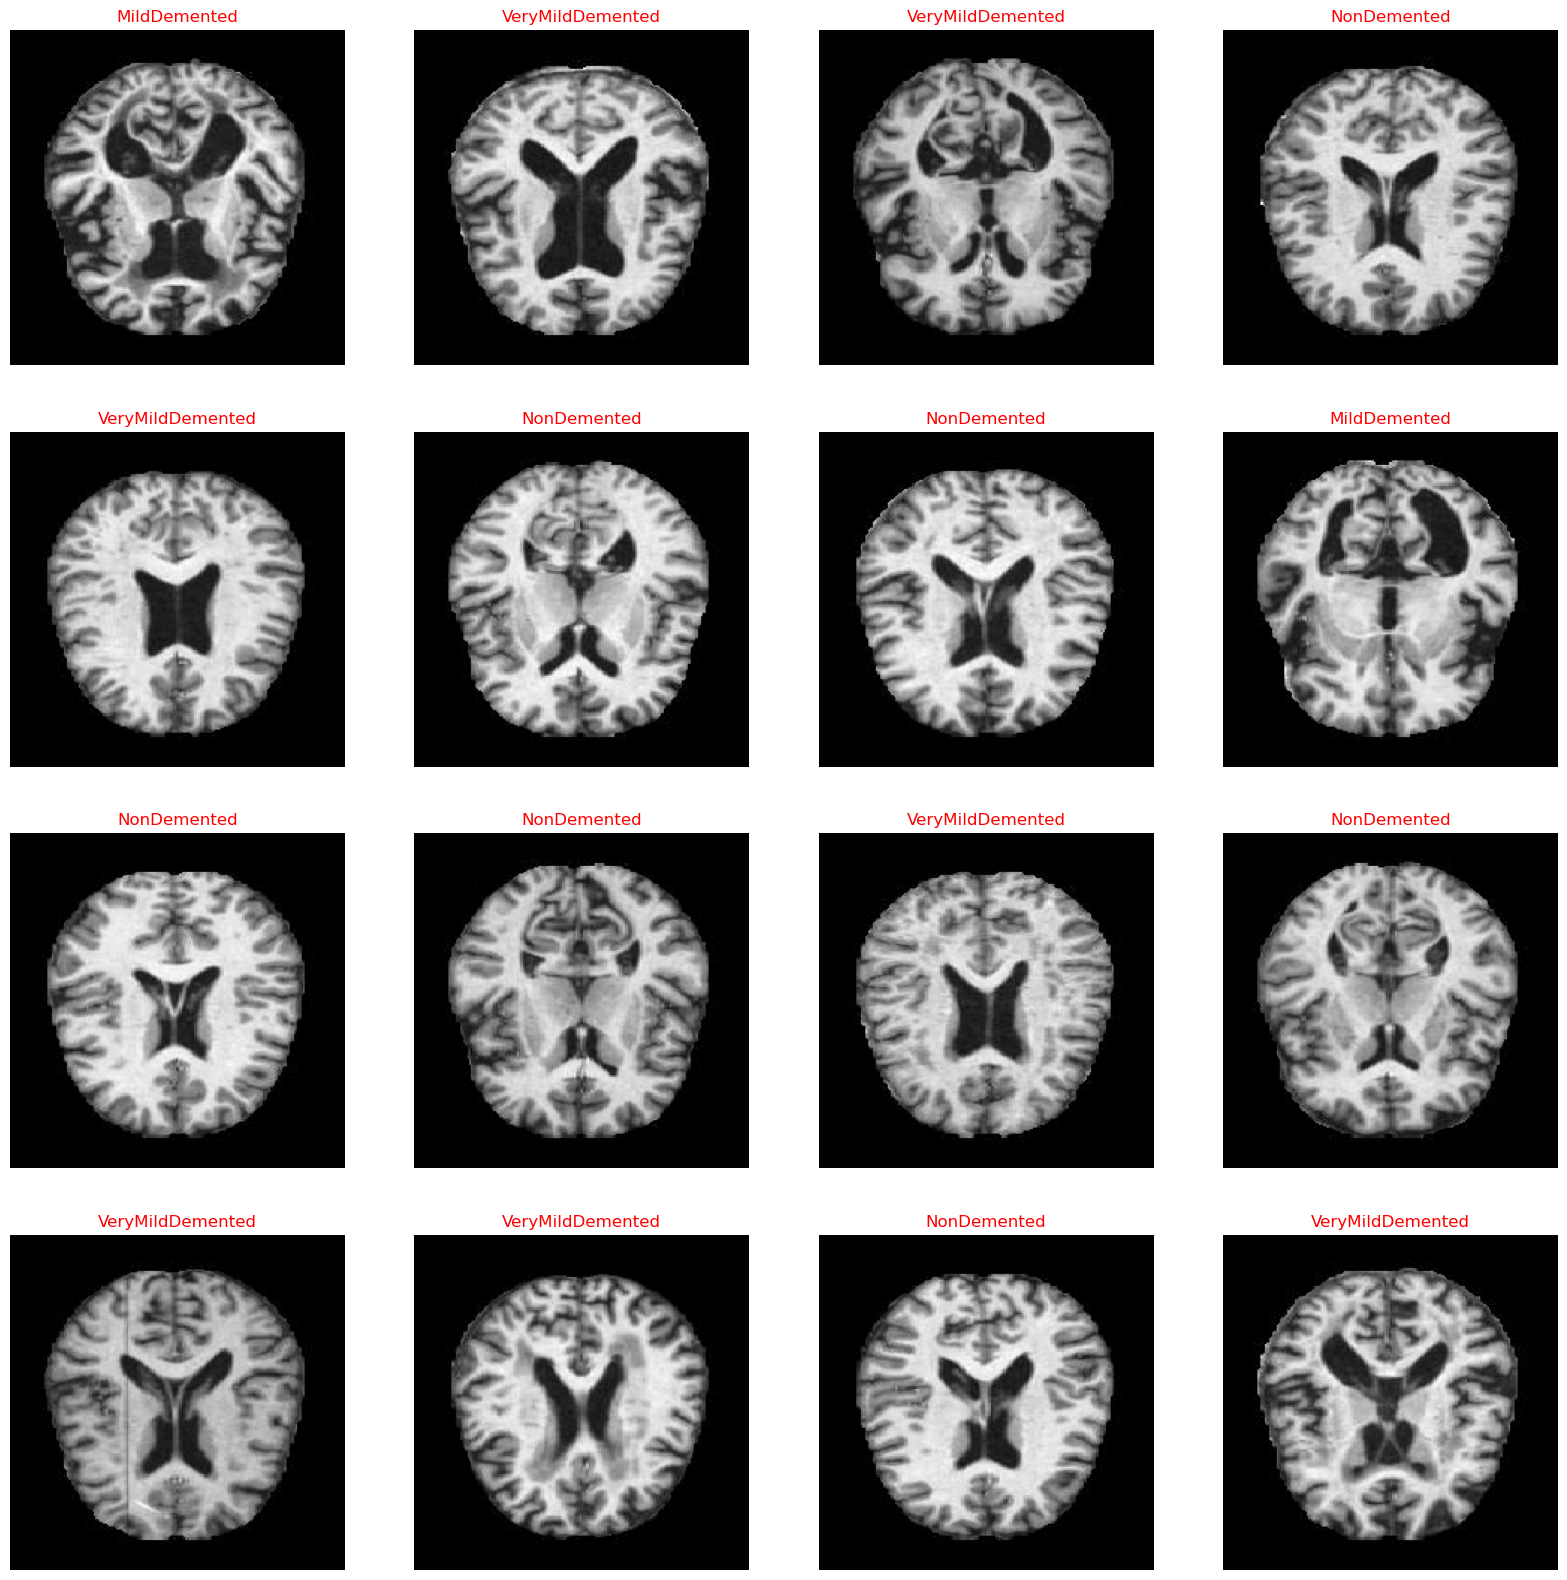

In [9]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'red', fontsize= 12)
    plt.axis('off')
plt.show()

In [10]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42)

train_data, train_labels = train_data_gen.next()

print(train_data.shape, train_labels.shape)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(6400, 150, 150, 3) (6400, 4)
(12800, 150, 150, 3) (12800, 4)


In [11]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [12]:
inception_model = InceptionV3(input_shape=(150, 150, 3), include_top=False, weights="imagenet")

In [13]:
for layer in inception_model.layers:
    layer.trainable=False

In [14]:
custom_inception_model = Sequential([
        inception_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name = "inception_cnn_model")

In [15]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

# CALLBACKS = rop_callback
    
custom_inception_model.compile(optimizer='adam',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

custom_inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 3, 3, 2048)        0         
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 512)       

In [16]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 20

history = custom_inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=EPOCHS)

Epoch 1/20
256/256 [==============================] - 238s 871ms/step - loss: 1.4353 - accuracy: 0.7349 - precision: 0.4450 - recall: 0.2451 - auc: 0.6513 - val_loss: 0.8422 - val_accuracy: 0.8263 - val_precision: 0.8055 - val_recall: 0.4023 - val_auc: 0.8726
Epoch 2/20
256/256 [==============================] - 224s 876ms/step - loss: 0.9714 - accuracy: 0.8020 - precision: 0.6873 - recall: 0.3817 - auc: 0.8255 - val_loss: 0.7073 - val_accuracy: 0.8444 - val_precision: 0.8224 - val_recall: 0.4814 - val_auc: 0.9058
Epoch 3/20
256/256 [==============================] - 221s 862ms/step - loss: 0.8520 - accuracy: 0.8202 - precision: 0.7414 - recall: 0.4309 - auc: 0.8634 - val_loss: 0.6580 - val_accuracy: 0.8489 - val_precision: 0.8342 - val_recall: 0.4937 - val_auc: 0.9190
Epoch 4/20
256/256 [==============================] - 225s 881ms/step - loss: 0.7876 - accuracy: 0.8324 - precision: 0.7704 - recall: 0.4694 - auc: 0.8864 - val_loss: 0.6281 - val_accuracy: 0.8577 - val_precision: 0.8182

In [17]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

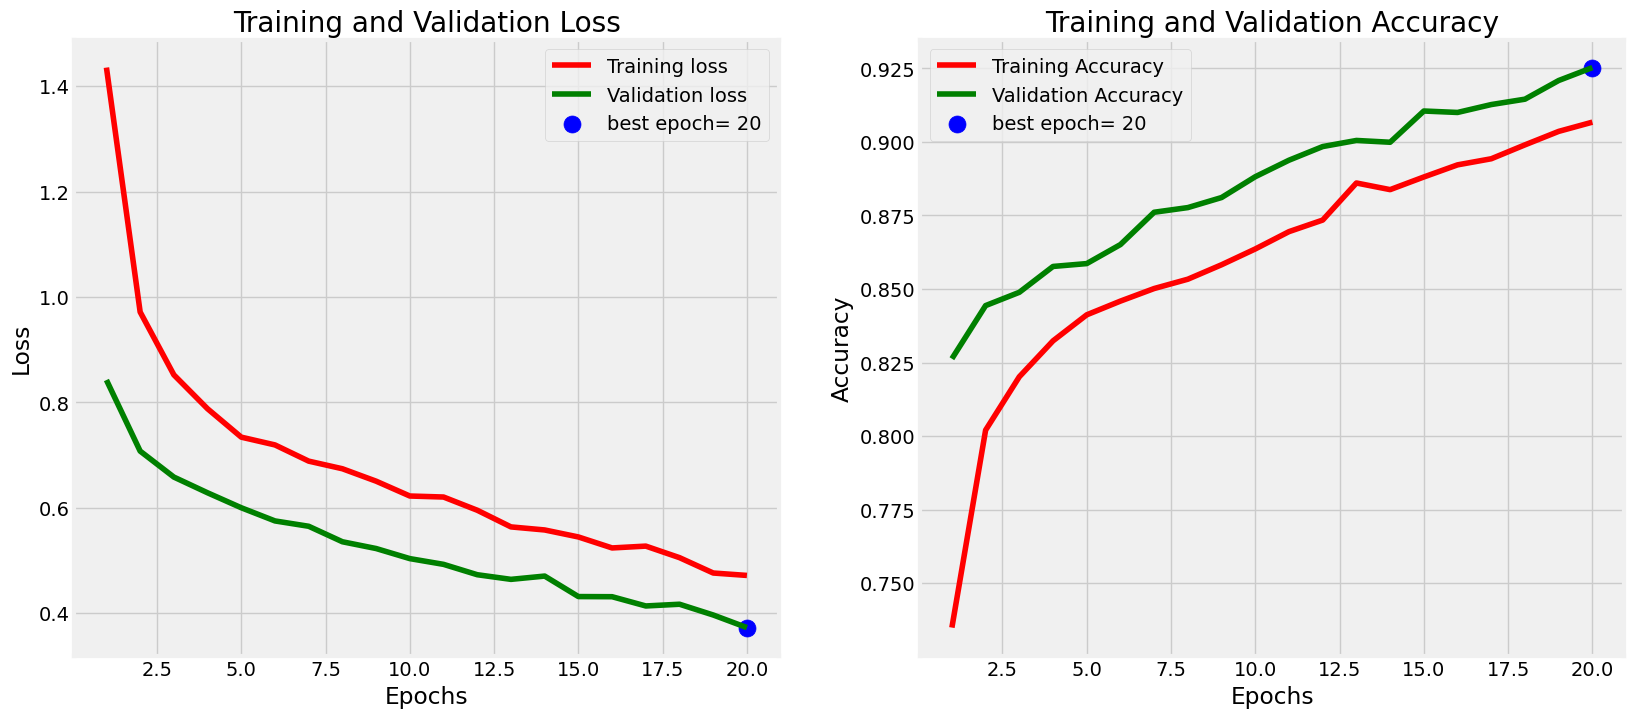

In [18]:
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

In [19]:
#Evaluating the model on the data

test_scores = custom_inception_model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 54s 671ms/step - loss: 0.4243 - accuracy: 0.9122 - precision: 0.8456 - recall: 0.7937 - auc: 0.9669
Testing Accuracy: 91.22%


In [20]:
#Predicting the test data
pred_labels = custom_inception_model.predict(test_data)

80/80 [==============================] - 57s 683ms/step


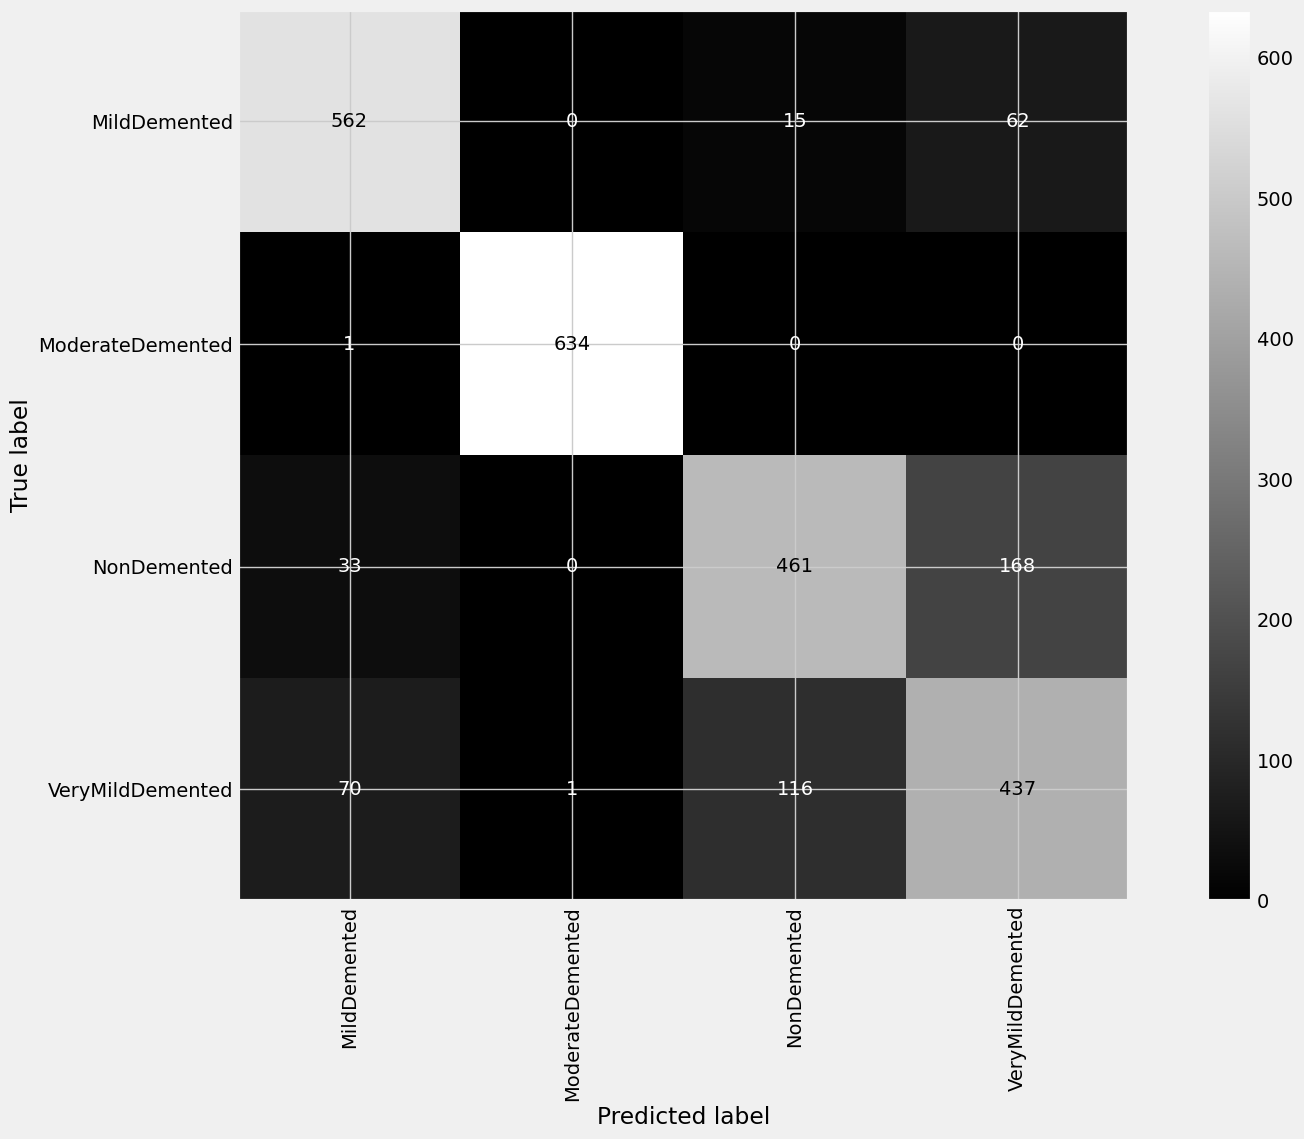

In [21]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)
from sklearn.metrics import ConfusionMatrixDisplay

labels = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

disp = ConfusionMatrixDisplay(confusion_matrix=conf_arr,
                              display_labels=labels)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(18, 11))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='gray')

plt.show()

In [22]:
# Save the model
custom_inception_model.save('my_model.h5')

# Load the model
loaded_model = tf.keras.models.load_model('my_model.h5', compile=False)


c:\Users\Eng Gehad\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
from PIL import Image
import numpy as np

image_path = 'C:/Users/Eng Gehad/Documents/Graduation Project/Alzheimer_s Dataset/test/NonDemented/26 (62).jpg'
image = Image.open(image_path)

# Convert the image to RGB format
img = image.convert("RGB")

# Preprocess the image
img = img.resize((150, 150))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Check if the image is loaded correctly
if img:
    # Make predictions
    predictions = loaded_model.predict(img_array)
    class_labels = train_gen.class_indices
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = list(class_labels.keys())[list(class_labels.values()).index(predicted_class_index)]
    print(f"Predicted class: {predicted_class}")
else:
    print("Error: Unable to load the image.")


1/1 [==============================] - 0s 63ms/step
Predicted class: NonDemented
